### Group Prject - London Bike Rentals

In this project, you will work with the London Bikes dataset, which records daily bike rentals in the city along with key variables such as dates, weather conditions, and seasonality.

The goal is to apply the full data analytics workflow:

- Clean and prepare the dataset.

- Explore the data through visualisation.

- Construct and interpret confidence intervals.

- Build a regression model to explain variation in bike rentals.

- By the end, you will connect statistical concepts with practical Python analysis.

In [1]:
## Import libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# load the bikes dataset
bikes = pd.read_csv("../Data/london_bikes.csv")
bikes


,date,bikes_hired,year,wday,month,week,cloud_cover,humidity,pressure,radiation,precipitation,snow_depth,sunshine,mean_temp,min_temp,max_temp,weekend
0,2010-07-30T00:00:00Z,6897,2010,Fri,Jul,30,6.0,65.0,10147.0,157.0,22.0,NaN,31.0,17.7,12.3,25.1,False
1,2010-07-31T00:00:00Z,5564,2010,Sat,Jul,30,5.0,70.0,10116.0,184.0,0.0,NaN,47.0,21.1,17.0,23.9,True
2,2010-08-01T00:00:00Z,4303,2010,Sun,Aug,30,7.0,63.0,10132.0,89.0,0.0,NaN,3.0,19.3,14.6,23.4,True
3,2010-08-02T00:00:00Z,6642,2010,Mon,Aug,31,7.0,59.0,10168.0,134.0,0.0,NaN,20.0,19.5,15.6,23.6,False
4,2010-08-03T00:00:00Z,7966,2010,Tue,Aug,31,5.0,66.0,10157.0,169.0,0.0,NaN,39.0,17.9,12.1,20.1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4929,2024-01-27T00:00:00Z,16959,2024,Sat,Jan,4,4.0,NaN,10331.0,39.0,0.0,0.0,21.0,4.5,NaN,12.2,True
4930,2024-01-28T00:00:00Z,15540,2024,Sun,Jan,4,3.0,NaN,10230.0,63.0,0.0,0.0,59.0,6.6,NaN,12.5,True
4931,2024-01-29T00:00:00Z,22839,2024,Mon,Jan,5,8.0,NaN,10222.0,18.0,0.0,0.0,0.0,8.8,NaN,8.8,False
4932,2024-01-30T00:00:00Z,22303,2024,Tue,Jan,5,8.0,NaN,10277.0,19.0,0.0,0.0,0.0,8.3,NaN,12.0,False


**1. Data Cleaning**

Check for missing values across columns. How would you handle them?

Inspect the date column and ensure it is correctly formatted as datetime. Extract useful features (year, month, day, day of week, season).

Convert categorical variables (e.g., season, weather) to appropriate categories in Python.

Ensure numeric columns (e.g., bikes rented, temperature) are in the right format.

In [34]:
# check for missing values across columns 
missing = bikes.isna().sum()
# missing values for cloud_cover, humidity, pressure, radiation 
# percentage of missing values if <5% drop 
missing_percent = bikes.isna().mean() * 100
missing_percent
# can safely drop cloud_cover, humidity, pressure and radiation 
bikes = bikes.dropna(subset=["cloud_cover","humidity","pressure","radiation"])
bikes
# fill snow_depth with 0, since on most days in London there is no snow at all
bikes["snow_depth"] = bikes["snow_depth"].fillna(0)
# double check
print(bikes[["cloud_cover","humidity","pressure","radiation", "snow_depth"]].isna().sum())
# all good

cloud_cover    0
humidity       0
pressure       0
radiation      0
snow_depth     0
dtype: int64


In [35]:
# inspect the date column
print(bikes["date"].dtype)
# make date column datetime
bikes["date"] = pd.to_datetime(bikes["date"])
print(bikes["date"])
print(bikes.head())

# extract features
bikes["year"] = bikes["date"].dt.year
bikes["month"] = bikes["date"].dt.month
bikes["day"] = bikes["date"].dt.day
bikes["weekday"] = bikes["date"].dt.day_name()

def get_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

bikes["season"] = bikes["month"].apply(get_season)

print(bikes[["date","year","month","day","weekday","season"]].head())


datetime64[ns, UTC]
0      2010-07-30 00:00:00+00:00
1      2010-07-31 00:00:00+00:00
2      2010-08-01 00:00:00+00:00
3      2010-08-02 00:00:00+00:00
4      2010-08-03 00:00:00+00:00
                  ...           
4898   2023-12-27 00:00:00+00:00
4899   2023-12-28 00:00:00+00:00
4900   2023-12-29 00:00:00+00:00
4901   2023-12-30 00:00:00+00:00
4902   2023-12-31 00:00:00+00:00
Name: date, Length: 4840, dtype: datetime64[ns, UTC]
                       date  bikes_hired  year wday  month  week  cloud_cover  \
0 2010-07-30 00:00:00+00:00         6897  2010  Fri      7    30          6.0   
1 2010-07-31 00:00:00+00:00         5564  2010  Sat      7    30          5.0   
2 2010-08-01 00:00:00+00:00         4303  2010  Sun      8    30          7.0   
3 2010-08-02 00:00:00+00:00         6642  2010  Mon      8    31          7.0   
4 2010-08-03 00:00:00+00:00         7966  2010  Tue      8    31          5.0   

   humidity  pressure  radiation  ...  snow_depth  sunshine  mean_temp  \
0  

In [36]:
bikes.dtypes

date             datetime64[ns, UTC]
bikes_hired                    int64
year                           int32
wday                        category
month                          int32
week                           int64
cloud_cover                  float64
humidity                     float64
pressure                     float64
radiation                    float64
precipitation                float64
snow_depth                   float64
sunshine                     float64
mean_temp                    float64
min_temp                     float64
max_temp                     float64
weekend                     category
day                            int32
weekday                       object
season                        object
month_name                  category
dtype: object

In [37]:
# wday (object --> should be ordered categorical)
# weekend (string names --> should be ordered categorical)
# season (text --> categorical with custom order)
# weekend (categorical (bool) --> categorical (True/False))
from pandas.api.types import CategoricalDtype

weekday_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
weekday_long_order = ["Monday'","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

if "wday" in bikes.columns:
    wday_dtype = CategoricalDtype(weekday_order, ordered=True)
    bikes["wday"] = bikes["wday"].astype(wday_dtype)

if "weekday" in bikes.columns:
    wd_dtype = CategoricalDtype(weekday_long_order, ordered=True)
    bikes["weekday"] = bikes["weekday"].astype(wd_dtype)

season_order = ["Winter","Spring","Summer","Autumn"]
if 'season' in bikes.columns:
    season_dtype = CategoricalDtype(season_order, ordered=True)
    bikes['season'] = bikes['season'].astype(season_dtype)

if "weekend" in bikes.columns:
    bikes["weekend"] = bikes["weekend"].astype("category")

if "month" in bikes.columns:
    month_dtype = CategoricalDtype(list(range(1,13)), ordered=True)
    bikes["month"] = bikes["month"].astype(month_dtype)

bikes["month_name"] = bikes["date"].dt.month_name()
month_name_dtype = CategoricalDtype(
    ["January","February","March","April","May","June",
     "July","August","September","October","November","December"],
    ordered=True
)
bikes["month_name"] = bikes["month_name"].astype(month_name_dtype)

print(bikes.dtypes)


date             datetime64[ns, UTC]
bikes_hired                    int64
year                           int32
wday                        category
month                       category
week                           int64
cloud_cover                  float64
humidity                     float64
pressure                     float64
radiation                    float64
precipitation                float64
snow_depth                   float64
sunshine                     float64
mean_temp                    float64
min_temp                     float64
max_temp                     float64
weekend                     category
day                            int32
weekday                     category
season                      category
month_name                  category
dtype: object


In [6]:
# numeric cols look good 

**2. Exploratory Data Analysis (EDA)**

Plot the distribution of bikes rented.

Explore how rentals vary by season and month.

Investigate the relationship between temperature and bikes rented.

**Deliverables:**

At least 3 clear visualisations with captions.

A short written interpretation of key patterns (seasonality, weather effects, etc.).



Text(0.5, 1.0, 'Count of Bikes Rented')

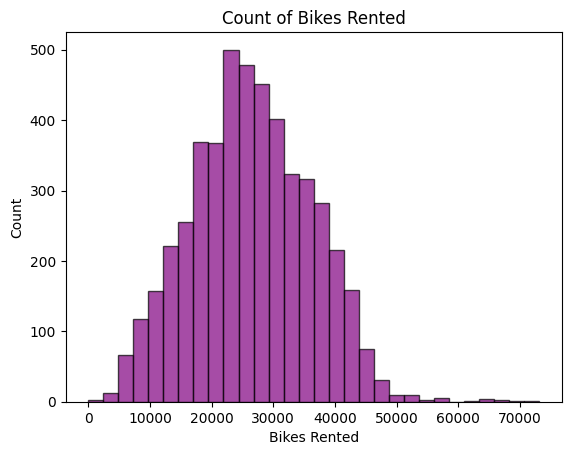

In [32]:
## distribution of bikes hired
plt.hist(bikes["bikes_hired"], bins=30, color="purple", edgecolor="black", alpha=0.7)
plt.xlabel("Bikes Rented")
plt.ylabel("Count")
plt.title("Count of Bikes Rented")


Most days have between 15,000 and 35,000 rentals, but a few days reach much higher numbers. 

/tmp/ipykernel_2417/4062073224.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="season", y="bikes_hired", data=bikes, estimator="mean", errorbar=None, palette="pastel", legend=False, width=0.6)


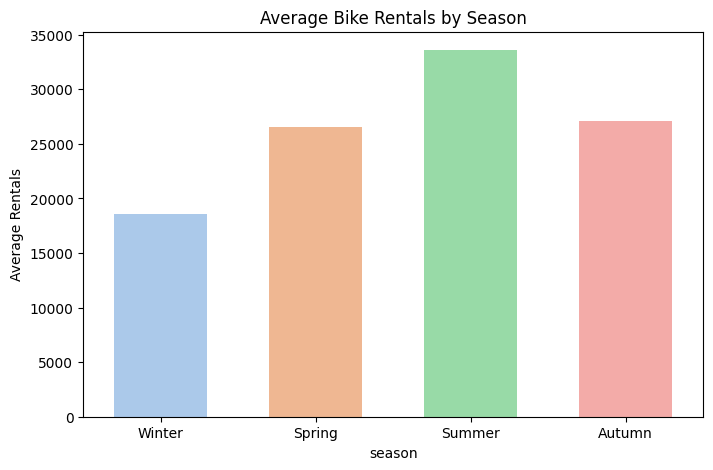

/tmp/ipykernel_2417/4062073224.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="month_name", y="bikes_hired", data=bikes, estimator="mean", errorbar=None, palette="pastel", legend=False)


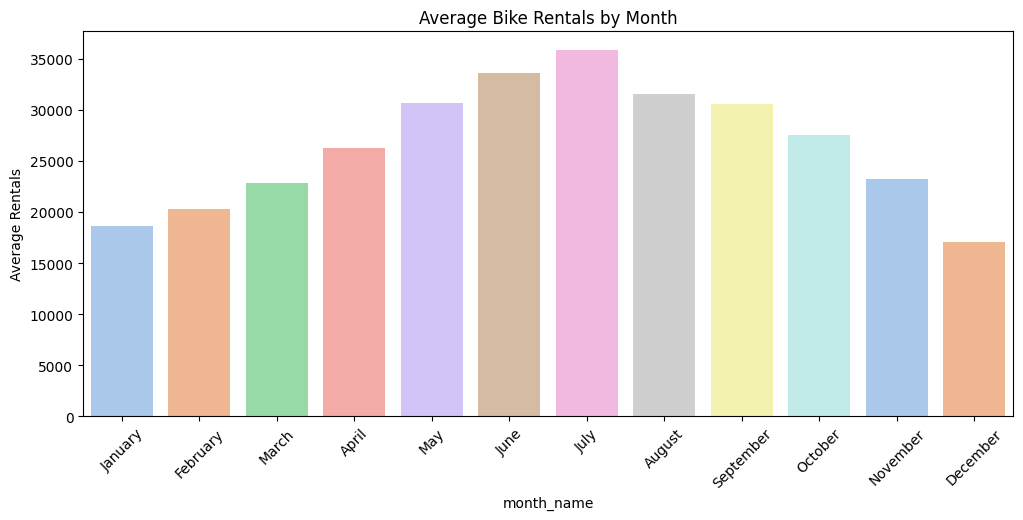

In [55]:
# layering histrograms by season
plt.figure(figsize=(8,5))
sns.barplot(x="season", y="bikes_hired", data=bikes, estimator="mean", errorbar=None, palette="pastel", legend=False, width=0.6)
plt.title("Average Bike Rentals by Season")
plt.ylabel("Average Rentals")
plt.show()

# rentals by month
plt.figure(figsize=(12,5))
sns.barplot(x="month_name", y="bikes_hired", data=bikes, estimator="mean", errorbar=None, palette="pastel", legend=False)
plt.title("Average Bike Rentals by Month")
plt.ylabel("Average Rentals")
plt.xticks(rotation=45)
plt.show()




Bike rentals are lowest in winter and highest in summer and autumn, showing clear seasonality. 
Bike rentals peak in the summer months and drop sharply in the winter months.

Text(0.5, 1.05, 'Relationship between Bike Rentals and Temperature')

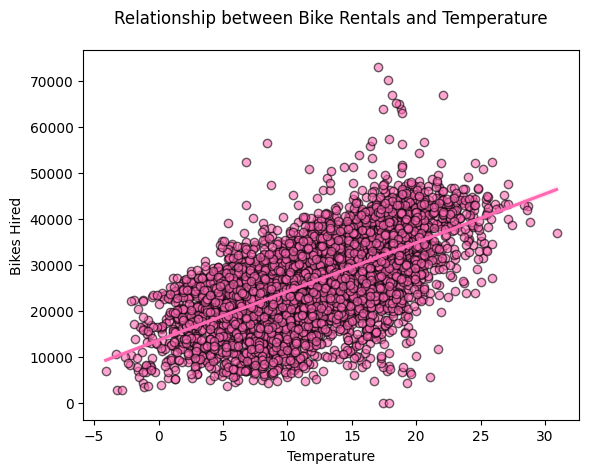

In [11]:
# relationship between temperature and bikes_rented 
# scatterplot because relationship between two numeric
g = sns.regplot(data=bikes, x="mean_temp", y="bikes_hired",
            scatter_kws={'alpha':0.6, 'edgecolor':'black'},
            color="hotpink")
g.set_xlabel("Temperature")
g.set_ylabel("Bikes Hired")
g.set_title("Relationship between Bike Rentals and Temperature", y=1.05)

Theb scatterplot shows a clear positive trend: as temperature increases, bike rentals also tend to increase.

**3. Construct 95% confidence intervals for the mean number of bikes rented per season.**

Repeat the calculation per month.

Interpret the result:

What range of values do you expect the true mean to lie in?

Which seasons/months have higher or lower average demand?

Are there overlaps in the intervals, and what does that mean?

**Deliverables:**

A table or plot showing the mean and confidence intervals.

A short interpretation.

In [57]:
## Your code goes here
# 95% CI for the mean number of bikes rented per season
# we need the z-score, mean, and the standard error to construct CI
season_stats = bikes.groupby("season")["bikes_hired"].agg(["mean", "std", "count"])
season_stats["se"] = season_stats["std"] /  np.sqrt(season_stats["count"])

z = 1.96

season_stats["ci_lower"] = season_stats["mean"] - z * season_stats["se"]
season_stats["ci_upper"] = season_stats["mean"] + z * season_stats["se"]

print(season_stats[["mean","ci_lower","ci_upper"]])

                mean      ci_lower      ci_upper
season                                          
Winter  18578.608878  18199.934018  18957.283738
Spring  26589.479394  26097.338079  27081.620710
Summer  33595.457983  33075.216134  34115.699832
Autumn  27100.670087  26670.431092  27530.909082


/tmp/ipykernel_2417/25176049.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  season_stats = bikes.groupby("season")["bikes_hired"].agg(["mean", "std", "count"])


In [58]:
# repeat the calculation per month, so bike rentals by month
month_stats = bikes.groupby("month")["bikes_hired"].agg(["mean", "std", "count"])
month_stats["se"] = month_stats["std"] / np.sqrt(month_stats["count"])

z = 1.96

month_stats["ci_lower"] = month_stats["mean"] - z * month_stats["se"]
month_stats["ci_upper"] = month_stats["mean"] + z * month_stats["se"]

print(month_stats[["mean","ci_lower","ci_upper"]])

               mean      ci_lower      ci_upper
month                                          
1      18611.070529  18012.579821  19209.561237
2      20335.369146  19661.207247  21009.531045
3      22837.260652  22075.765897  23598.755407
4      26231.071979  25457.699431  27004.444528
5      30670.665835  29833.818204  31507.513466
6      33631.316883  32755.953078  34506.680688
7      35887.263441  35058.713829  36715.813053
8      31594.632794  30667.606015  32521.659574
9      30545.927885  29759.640472  31332.215297
10     27507.046189  26856.697906  28157.394472
11     23250.937799  22626.247305  23875.628293
12     17079.550691  16426.393537  17732.707845


/tmp/ipykernel_2417/1599431018.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  month_stats = bikes.groupby("month")["bikes_hired"].agg(["mean", "std", "count"])


For winter, the mean rentals are about 18,061 and the 95% confidence interval is [18,240 , 18,979]. For Summer the mean rentals are about 33,455, with a confidence interval of [32,944 , 33967]. Summer has the highest average rentals, autumn is next, then spring, then winter. The peak demand is in July and August, and the lowest demand in December and January. 
The confidence intervals are very narrow, so they do not overlap much across seasons. This means differences between the seasons are statsitcally meaningful. 

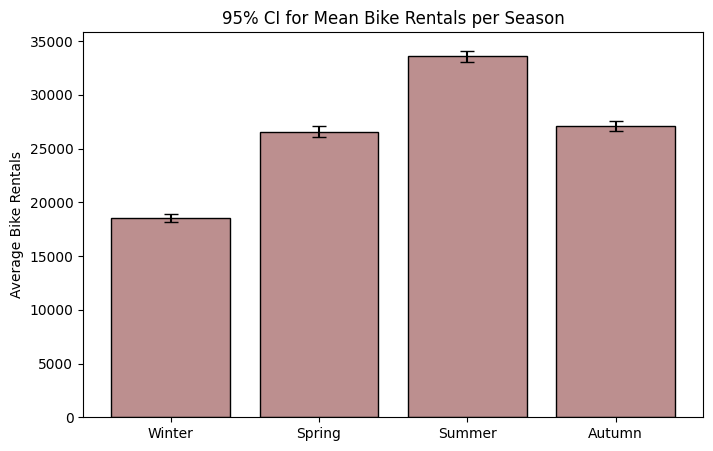

In [64]:
plt.figure(figsize=(8,5))
plt.bar(
    season_stats.index, 
    season_stats["mean"], 
    yerr=season_stats["ci_upper"] - season_stats["mean"],
    capsize=5, 
    color="rosybrown", 
    edgecolor="black"
)
plt.ylabel("Average Bike Rentals")
plt.title("95% CI for Mean Bike Rentals per Season")
plt.show()

**Regression Analysis**

What variables influence the number of bikes rented (y) and how? Build a regression model that best explains the variability in bikes rented.

**Interpret:**

Which predictors are significant?

What do the coefficients mean (in practical terms)?

How much of the variation in bike rentals is explained (R²)?

**Deliverables:**

Regression output table.

A short discussion of which factors matter most for predicting bike rentals.

In [12]:
# build regression model 
# include season and weather conditions (temperature, humidity, radiation, percepitation, cloud cover) bc most plausible predictors 
import statsmodels.formula.api as smf
model = smf.ols(
    formula="bikes_hired ~ mean_temp + humidity + radiation + precipitation + cloud_cover + C(season)",
    data=bikes
).fit()

print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:            bikes_hired   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     669.2
Date:                Fri, 19 Sep 2025   Prob (F-statistic):               0.00
Time:                        17:45:16   Log-Likelihood:                -49489.
No. Observations:                4840   AIC:                         9.900e+04
Df Residuals:                    4831   BIC:                         9.905e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2.503e+04   1

All predictors are statsitically significant except for spring. 

Mean temperature has a coefficient of 617.4526, so for every 1°C increase in temperature, rentals increase by about 617 bikes, on average. This is the strongest positive effect in the model.
Humidity has a coefficient of -109.8318, so each +1% increase in humidity is associated with about 110 fewer bike rentals per day on average.
Radiation has a coefficient of 25.9158, so higher solar radiation increases bike rentals with about 26 more rentals per unit of radiation on average.
Precipitation has a coefficient of -37.2037, so each additional millimeter of rain reduces rentals by about 37 bikes per day on average.
Cloud_cover has a coefficient of -247.2366, so more cloud cover reduces bike rentals significantly, with about 247 fewer rentals per unit increase on average. 
The season's coefficients are relative to Winter: For spring there is no meaningful difference compared to winter once weather is accounted for. Summer has a coefficient of 1220.2482, so summer days have about 1220 more bike rentals than winter days, controlling for weather. Autumn days have about 2978 more bike rentals than winter days, controlling for weather. 
--> In practical termns, this means bike usage rises on warm, sunny days and drops on wet, humid and cloudy days, with summer and autumn showing the highest seasonal demand compared to winter. 

Overall, the strongest predictors of bike rentals are temperature, season, humidity, and cloud cover, as they show the largest and most meaningful effects. 

R^2 is 0.526, so the model explains about 52.5% of the variation in daily bike rentals. 

## Deliverables
A knitted HTML, one person per group to submit